# Potato Disease Predictor Training

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Reading the data and splitting it

In [2]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../../Data/',
    shuffle=True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

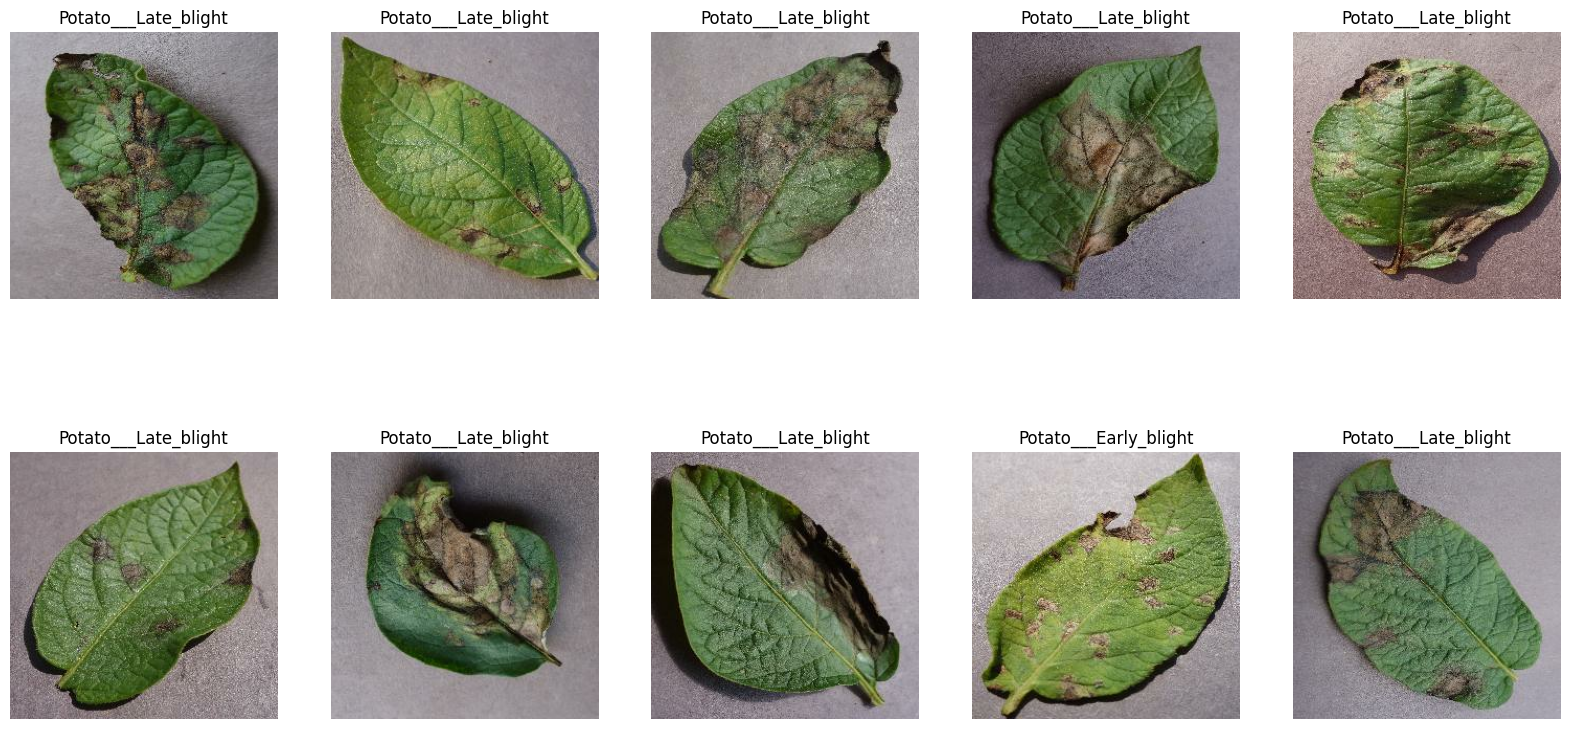

In [6]:
plt.figure(figsize=(20, 10))

for image_batch, label_batch in dataset.take(2):
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# 80% data goes for traing, 10% for validation and 10% for testing
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)

In [8]:
rem_ds = dataset.skip(int(0.8 * len(dataset)))

In [9]:
valid_ds = rem_ds.take(int(0.5*len(rem_ds)))
test_ds = rem_ds.skip(int(0.5*len(rem_ds)))

In [10]:
len(train_ds), len(valid_ds), len(test_ds)

(54, 7, 7)

In [11]:
# Optimizing the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Scaling and preprocessing

In [12]:
resizeRescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
dataAug = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

## Model Building using CNN

In [14]:
nClasses = 3
inputShape = (BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

In [15]:
model = keras.Sequential([
    resizeRescale,
    dataAug,
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=inputShape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=inputShape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=inputShape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputShape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=inputShape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(nClasses, activation='softmax')
])

model.build(input_shape=inputShape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=valid_ds
)

Epoch 1/50
54/54 [==============================] - 101s 2s/step - loss: 0.9065 - accuracy: 0.5110 - val_loss: 0.7506 - val_accuracy: 0.6920
Epoch 2/50
54/54 [==============================] - 93s 2s/step - loss: 0.6252 - accuracy: 0.7251 - val_loss: 0.4646 - val_accuracy: 0.8438
Epoch 3/50
54/54 [==============================] - 95s 2s/step - loss: 0.5022 - accuracy: 0.8073 - val_loss: 0.5598 - val_accuracy: 0.7946
Epoch 4/50
54/54 [==============================] - 94s 2s/step - loss: 0.3756 - accuracy: 0.8501 - val_loss: 0.2675 - val_accuracy: 0.8973
Epoch 5/50
54/54 [==============================] - 95s 2s/step - loss: 0.3084 - accuracy: 0.8791 - val_loss: 0.2786 - val_accuracy: 0.8929
Epoch 6/50
54/54 [==============================] - 100s 2s/step - loss: 0.3384 - accuracy: 0.8553 - val_loss: 0.2986 - val_accuracy: 0.8929
Epoch 7/50
54/54 [==============================] - 100s 2s/step - loss: 0.2974 - accuracy: 0.8791 - val_loss: 0.2449 - val_accuracy: 0.8929
Epoch 8/50
54/54 

In [19]:
model.evaluate(test_ds)

7/7 [==============================] - 10s 482ms/step - loss: 0.1167 - accuracy: 0.9750


[0.11667297035455704, 0.9750000238418579]

In [20]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
trainAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']

trainLoss = history.history['loss']
valLoss = history.history['val_loss']

Text(0.5, 1.0, 'Training v/s Validation Accuracy')

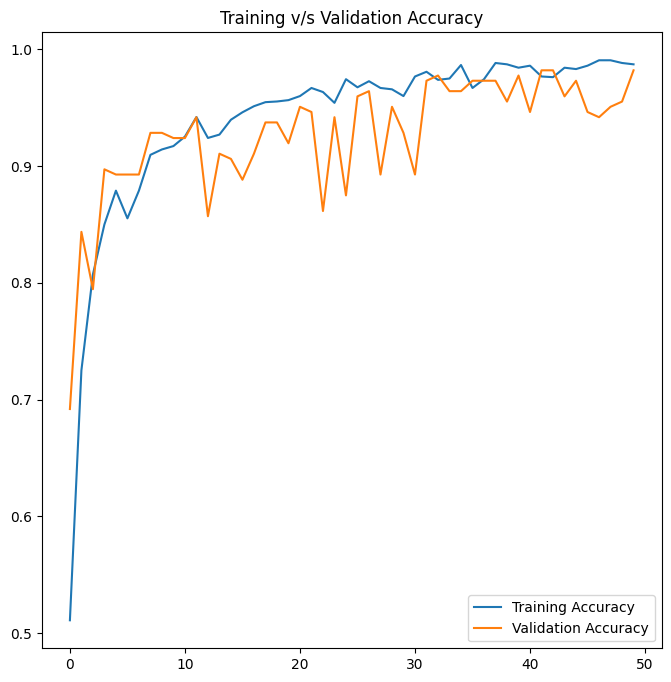

In [23]:
plt.figure(figsize=(8, 8))
plt.plot(range(50), trainAcc, label='Training Accuracy')
plt.plot(range(50), valAcc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training v/s Validation Accuracy')

Text(0.5, 1.0, 'Training v/s Validation Loss')

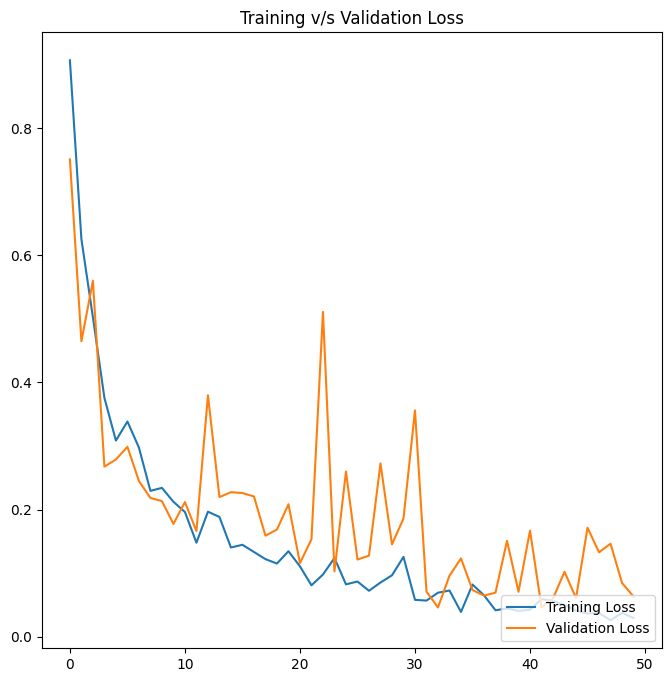

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(range(50), trainLoss, label='Training Loss')
plt.plot(range(50), valLoss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training v/s Validation Loss')

1/1 [==============================] - 1s 714ms/step
Actual Label: Potato___Early_blight
Predicted Label: Potato___Early_blight
Confidence Level: 100.0%


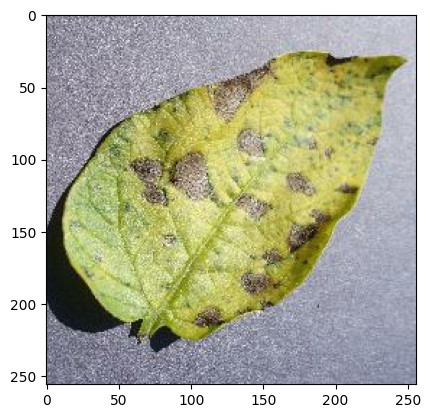

In [25]:
for imagesBatch, labelsBatch in test_ds.take(1):
    firstImage = imagesBatch[0].numpy().astype('uint8')
    firstLabel = labelsBatch[0].numpy()

    batchPred = model.predict(imagesBatch)

    plt.imshow(firstImage)
    print(f"Actual Label: {class_names[firstLabel]}\nPredicted Label: {class_names[np.argmax(batchPred[0])]}")
    print(f"Confidence Level: {round(100 * np.max(batchPred[0]), 3)}%")

In [26]:
modelVersion = 3
model.save(f"../Models/{modelVersion}")

INFO:tensorflow:Assets written to: ../Models/3\assets


INFO:tensorflow:Assets written to: ../Models/3\assets


In [27]:
model.save('../potatoModel.h5')

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
